In [1]:
import torch
from d2l import torch as d2l
from IPython import display

## 一、多层感知机原理

#### 1)4.1章节中，手写leakyRelu的实现函数，并绘制其对应的函数曲线图与导数曲线图。查阅资料简略解释Relu、leakyRelu和pRelu的关系及优缺点。

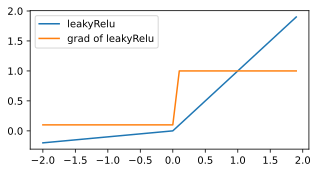

In [2]:
# 手写leakyRelu的实现函数
def leakyRelu(x, alpha=0.1):
    return torch.max(alpha * x, x)

x = torch.arange(-2.0, 2.0, 0.1)
x.requires_grad_(True)
y = leakyRelu(x)

# 绘制导数曲线图 
y = torch.autograd.grad(y, x, torch.ones_like(x), retain_graph=True)[0]
# 创建两个画板
d2l.set_figsize((5, 2.5))
# 绘制leakyRelu函数图像
d2l.plt.plot(x.detach().numpy(), leakyRelu(x).detach().numpy(), label='leakyRelu')
# 绘制leakyRelu函数的导数图像
d2l.plt.plot(x.detach().numpy(), y.detach().numpy(), label='grad of leakyRelu')
# 显示图例
d2l.plt.legend()
# 保存图里到本地
d2l.plt.savefig('../media/leakyRelu.png')


ReLU(Rectified Linear Unit, 整流线性单元)、Leaky ReLU和PReLU都是常用的非线性激活函数,它们具有以下关系和优缺点:

1. **ReLU(Rectified Linear Unit)**
   - 公式: f(x) = max(0, x)
   - 优点: 计算简单、收敛速度快,缓解梯度消失问题
   - 缺点: 对于负值输入会使神经元"死掉",无法恢复,存在"神经元死亡"问题

2. **Leaky ReLU**
   - 公式: f(x) = max(αx, x)  (α通常取0.01或0.1)
   - 优点: 解决了ReLU的"神经元死亡"问题
   - 缺点: α值选择较为主观,对负值的学习能力有限

3. **PReLU(Parametric Rectified Linear Unit)**
   - 公式: f(x) = max(αx, x)  (α为可学习参数)
   - 优点: 不同通道可以学习不同的α值,因此拟合能力更强
   - 缺点: 引入了额外参数,增加了计算量和模型复杂度

**关系**:
- ReLU是最简单的线性整流函数
- Leaky ReLU是对ReLU的改进,解决了死亡神经元问题
- PReLU是进一步对Leaky ReLU的改进,使α可学习,增强了模型的表达能力

**优缺点**:
- ReLU最简单,无参数可学习,但有死亡神经元问题
- Leaky ReLU解决了神经元死亡问题,但α值固定,缺乏灵活性
- PReLU最灵活,α值可学习,拟合能力最强,但增加了计算量



#### 2）4.2章节从零实现多层感知机中，再添加一层隐藏层(64个隐藏单元)，训练轮数为10，对比一下测试精度有何变化，如果增加训练轮数，再观察两个隐藏层与一个隐藏层的测试精度的变化，尝试解释一下

In [3]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
import torch.utils.data as Data

batch_size = 256
trans = torchvision.transforms.ToTensor()

mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

train_loader = Data.DataLoader(mnist_train, batch_size, shuffle=True,
                                    num_workers=1)
test_loader =Data.DataLoader(mnist_test, batch_size, shuffle=False,
                                    num_workers=1)


In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256


# 隐藏层
W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

# 输出层
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

# 激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [5]:
num_inputs, num_outputs, num_hiddens = 784, 10, [256,64]
num_hidden_layers = len(num_hiddens)

# 隐藏层_1
W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens[0], requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens[0], requires_grad=True))

# 隐藏层_2
W2 = nn.Parameter(torch.randn(
    num_hiddens[0], num_hiddens[1], requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_hiddens[1], requires_grad=True))

hidden_layers_weights = [W1,W2]
hidden_layers_bias = [b1,b2]

# 输出层
W3 = nn.Parameter(torch.randn(
    num_hiddens[1], num_outputs, requires_grad=True) * 0.01)
b3 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2, W3, b3]

# 激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [6]:
# 定义网络
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [7]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('b-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
    def save_fig(self, filename):
        # 保存当前动画的最终状态到文件
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        self.fig.savefig(filename)

In [8]:
# 定义网络
def net(X):
    X = X.reshape((-1, num_inputs))
    for i in range(num_hidden_layers):
      H = relu(X@hidden_layers_weights[i] + hidden_layers_bias[i])  # 这里“@”代表矩阵乘法
      X = H
    return (H@W3 + b3)



In [9]:

# 大批量训练准备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F

class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size,NumOfHid):
        super(MyMLP, self).__init__()
        self.input_size = input_size    
        self.NumOfHid = NumOfHid
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.fc3_1 = nn.Linear(hidden_size1, output_size)
        self.fc2_2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3_2 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        if self.NumOfHid == 1:
            x = x.reshape(-1, self.input_size)
            x = F.relu(self.fc1(x))
            x = self.fc3_1(x)
        elif self.NumOfHid == 2:
            x = x.reshape(-1, self.input_size)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2_2(x))
            x = self.fc3_2(x)
        return x
    

In [10]:
import time
from datetime import datetime

# 增加时间戳


def evaluate_accuracy(model, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(model, torch.nn.Module):
        model.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y= y.to(device)
            metric.add(d2l.accuracy(model(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(model, train_loader, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(model, torch.nn.Module):
        model.train().to(device)
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_loader:
        # 计算梯度并更新参数
        X = X.to(device)
        y = y.to(device)

        y_hat = model(X)
        l = loss(y_hat, y).to(device)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

num_epochs, lr = 100, 0.1
num_inputs, num_outputs, num_hiddens = 784, 10, [256,64]

def train_ch3(model, train_loader, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(model, train_loader, loss, updater)
        test_acc = evaluate_accuracy(model, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
        # 获取当前时间戳
    # timestamp = int(time.time())
    # # 将时间戳转换为日期时间格式
    # dt_object = datetime.fromtimestamp(timestamp)
    # # 格式化日期时间
    # formatted_time = dt_object.strftime("%H:%M:%S_%Y-%m-%d")
    if NumOfHid == 1:
        animator.save_fig(f'../media/MLP_h{NumOfHid}_{num_epochs}_{num_hiddens[0]}.png')
    elif NumOfHid == 2:
        animator.save_fig(f'../media/MLP_h{NumOfHid}_{num_epochs}_{num_hiddens[0]}_{num_hiddens[1]}.png')
    
    train_loss, train_acc = train_metrics
    # assert train_loss < 0.5, train_loss
    # assert train_acc <= 1 and train_acc > 0.7, train_acc
    # assert test_acc <= 1 and test_acc > 0.7, test_acc

NumOfHid = 2

model = MyMLP(num_inputs, num_hiddens[0], num_hiddens[1], num_outputs,NumOfHid)
model.to(device)
loss = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# train_ch3(model,train_loader,test_loader,loss,num_epochs,optimizer)



进行多组实验后，发现当训练批量数较小时，单层隐藏层的MLP表现性能较好，但当增加更多批量数时，双层隐藏层的表现更好
原因：增加了隐藏层，就需要更多次学习来得到其中的权重，否则，学习不到理想结果的权重。


#### 3)	4.2章节中，通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？描述为什么涉及多个超参数更具挑战性？

涉及多个超参数会增加模型调优的挑战性，主要有以下几个方面：

维度爆炸：随着超参数数量的增加，搜索空间的维度也会指数级增长，这会导致参数空间的巨大扩展，使得寻找最佳组合变得更加困难。

相互影响：不同超参数之间可能存在相互影响的情况，调整一个超参数可能会对其他超参数产生影响，这种交互效应增加了优化过程的复杂性。

计算成本增加：搜索多个超参数的最佳组合需要进行大量的实验和计算，消耗更多的时间和计算资源。

过拟合风险增加：当有多个超参数需要调整时，存在过度拟合训练数据的风险，因为模型参数的选择范围更广，容易在训练集上表现良好，但在测试集上性能下降。

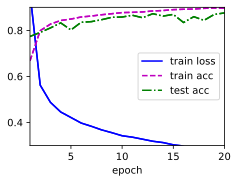

In [11]:
# 尝试获得最佳结果

NumOfHid = 2

num_epochs, lr = 20, 0.1
num_inputs, num_outputs, num_hiddens = 784, 10, [512,512]

model = MyMLP(num_inputs, num_hiddens[0], num_hiddens[1], num_outputs,NumOfHid)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_ch3(model,train_loader,test_loader,loss,num_epochs,optimizer)

#### 4)	4.3章节中，尝试添加不同数量的隐藏层（也可以修改学习率），尝试不同的激活函数，尝试不同的方案来初始化权重，选出你认为最优的超参数组合，获取最高的测试精度。

KeyboardInterrupt: 

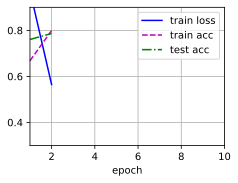

In [12]:
#可添加不同数量的隐藏层 三层隐藏层
import json

class DynamicMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes):
        super(DynamicMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        
        # 构建隐藏层之间的连接
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes) - 1)])
        
        # 构建最后一个隐藏层到输出层的连接
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # 前向传播过程
        x = x.reshape(-1, self.input_size)
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x


def train_ch3_plus(model, train_loader, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(model, train_loader, loss, updater)
        test_acc = evaluate_accuracy(model, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    result = {'loss': train_metrics[0], 'acc': train_metrics[1], 'test_acc': test_acc}
    # 将结果保存到文件
    if NumOfHid == 1:
        with open(f'../media/MLP_h{NumOfHid}_{num_epochs}_{hidden_sizes[1]}.json', 'w') as f:
            json.dump(result, f)
    elif NumOfHid == 2:
        with open(f'../media/MLP_h{NumOfHid}_{num_epochs}_{hidden_sizes[1]}_{hidden_sizes[2]}.json', 'w') as f:
            json.dump(result, f)
    elif NumOfHid == 3:
        with open(f'../media/MLP_h{NumOfHid}_{num_epochs}_{hidden_sizes[1]}_{hidden_sizes[2]}_{hidden_sizes[3]}.json', 'w') as f:
            json.dump(result, f)
        # 获取当前时间戳
    # timestamp = int(time.time())
    # # 将时间戳转换为日期时间格式
    # dt_object = datetime.fromtimestamp(timestamp)
    # # 格式化日期时间
    # formatted_time = dt_object.strftime("%H:%M:%S_%Y-%m-%d")
    if NumOfHid == 1:
        animator.save_fig(f'../media/MLP_h{NumOfHid}_{num_epochs}_{hidden_sizes[1]}.png')
    elif NumOfHid == 2:
        animator.save_fig(f'../media/MLP_h{NumOfHid}_{num_epochs}_{hidden_sizes[1]}_{hidden_sizes[2]}.png')
    elif NumOfHid == 3:
        animator.save_fig(f'../media/MLP_h{NumOfHid}_{num_epochs}_{hidden_sizes[1]}_{hidden_sizes[2]}_{hidden_sizes[3]}.png')
        
num_epochs = 10
input_size = 784
output_size = 10
hidden_sizes = [784, 512,512]  # 可以根据需要修改隐藏层的大小和数量
NumOfHid = len(hidden_sizes) - 1
loss = nn.CrossEntropyLoss(reduction='none')
model = DynamicMLP(input_size, output_size, hidden_sizes)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.to(device)
train_ch3_plus(model,train_loader,test_loader,loss,num_epochs,optimizer)

#### 5)	4.3章节中，nn.Flatten()是一个很重要的数据维度处理函数，它是怎样改变一个批次图像的形状，它与tensor.flatten()方法处理想过一样吗？如果想让其效果一致，怎么设置tensor.flatten()方法？如何用tensor.reshape()方法实现同样的效果？请设计代码验证。------（★★★，选做）

- 对于nn.Flatten() 

    它对于输入的张量，默认从axis=1一直展开到最后一维

- 对于torch.flatten()

    它对于输入的张量，默认从axis=0一直展开到最后一维

In [ ]:
import torch
import torch.nn as nn

# nn.Flatten
x = torch.randn(256,1,28,28)
# default param 默认从axis = 1开始Flatten
m = nn.Flatten()
x_m = m(x)
print(x_m.shape)



# torch.flatten
x = torch.randn(256,1,28,28)
x_f = torch.flatten(x)
print(x_f.shape)

x = torch.randn(256,1,28,28)
x_f = torch.flatten(x, start_dim=1)
print(x_f.shape)

# 使用torch.reshape
x = torch.randn(256,1,28,28)
x_r = torch.reshape(x, (-1, 1*28*28))
print(x_r.shape)

torch.Size([256, 784])
torch.Size([200704])
torch.Size([256, 784])
torch.Size([256, 784])


## 二、模型优化

#### 6)	4.4章节的多项式回归问题可以准确地解出吗（提示：使用线性代数）？并编程实现解析过程。

In [ ]:
import numpy as np
import math
import torch
# 生成数据集
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7984],
         [ 1.3790]]),
 tensor([[ 1.0000e+00, -7.9845e-01,  3.1876e-01, -8.4838e-02,  1.6935e-02,
          -2.7043e-03,  3.5987e-04, -4.1048e-05,  4.0969e-06, -3.6346e-07,
           2.9020e-08, -2.1065e-09,  1.4016e-10, -8.6085e-12,  4.9096e-13,
          -2.6134e-14,  1.3042e-15, -6.1253e-17,  2.7171e-18, -1.1418e-19],
         [ 1.0000e+00,  1.3790e+00,  9.5080e-01,  4.3705e-01,  1.5067e-01,
           4.1555e-02,  9.5506e-03,  1.8814e-03,  3.2431e-04,  4.9691e-05,
           6.8523e-06,  8.5903e-07,  9.8716e-08,  1.0471e-08,  1.0314e-09,
           9.4821e-11,  8.1723e-12,  6.6291e-13,  5.0786e-14,  3.6859e-15]]),
 tensor([2.4129, 5.7952]))

In [ ]:
# 以20为最高幂直接给出一个不确切的解析解 使用拉格朗日乘子法
dim_list = poly_features.shape
A_0 = torch.transpose(poly_features,0,1)@poly_features
b_0 = torch.transpose(poly_features,0,1)@labels.reshape(200,1)
X_0=torch.linalg.solve(A_0,b_0)
print(X_0)
print(torch.allclose(A_0 @ X_0, b_0)) # 检查是否准确

# 以3为最高幂直接给出解析解
dim_list_1 = poly_features[:,:4].shape
A_1 = torch.transpose(poly_features[:,:4],0,1)@poly_features[:,:4]
b_1 = torch.transpose(poly_features[:,:4],0,1)@labels.reshape(200,1)
X_1=torch.linalg.solve(A_1,b_1)
print(X_1)
print(torch.allclose(A_1 @ X_1, b_1)) # 检查是否准确

tensor([[ 5.0035e+00],
        [ 1.2184e+00],
        [-3.1969e+00],
        [ 5.7025e+00],
        [-5.1904e+00],
        [-1.5021e+00],
        [ 9.3413e+01],
        [-3.9206e+01],
        [-1.1838e+03],
        [ 1.9603e+03],
        [ 2.7572e+03],
        [-5.1927e+04],
        [ 2.7269e+05],
        [ 1.1029e+06],
        [-4.4937e+06],
        [-1.1139e+07],
        [ 7.1040e+07],
        [ 1.9550e+08],
        [-5.1337e+09],
        [-2.7927e+10]])
True
tensor([[ 5.0094],
        [ 1.2194],
        [-3.4236],
        [ 5.5488]])
True


#### 7)	4.4章节中，考虑多项式的模型选择，设epoch=400，绘制训练损失与模型复杂度（多项式的阶数）的关系图。你观察到了什么？理论上需要多少阶的多项式才能将训练损失减少到0? 

In [ ]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_loss,_, = d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    test_loss = evaluate_loss(net, test_iter, loss)
    print('train_loss:', train_loss,'test_loss:',test_loss)
    return train_loss,test_loss

train_loss: 0.028253219574689865 test_loss: 0.03323835119605065
[49.99604217529297, 46.03101593017578, 14.900608444213868, 3.295076160430908, 0.011712578088045121, 0.024923195168375968, 0.02586751036345959, 0.025940895825624467, 0.03108356714248657, 0.03073959767818451, 0.027531049475073816, 0.027828584536910058, 0.03010146826505661, 0.027216607332229616, 0.028829541355371475, 0.03259024053812027, 0.0324240317940712, 0.033986274749040604, 0.031999257802963255, 0.028253219574689865]
[48.620185699462894, 44.33859359741211, 17.12463798522949, 2.906651859283447, 0.009861996844410897, 0.022279352843761445, 0.0282831771671772, 0.031254740059375764, 0.0388164260238409, 0.03998601321130991, 0.03391661439090967, 0.033747169263660906, 0.03806244920939207, 0.03209136050194502, 0.03729948364198208, 0.042212333902716635, 0.04178723275661469, 0.04409690402448177, 0.04006035290658474, 0.03323835119605065]


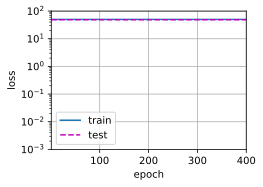

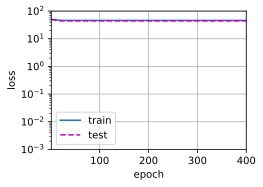

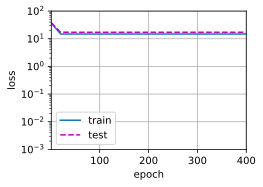

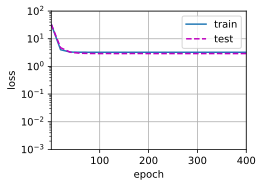

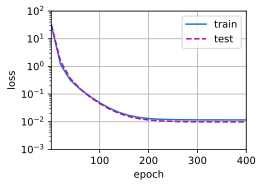

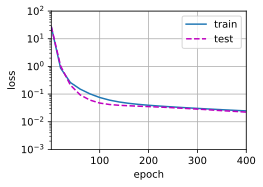

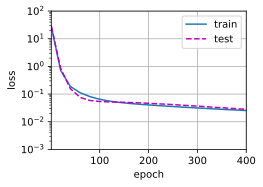

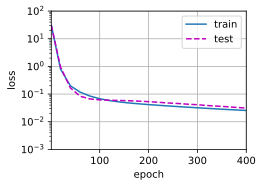

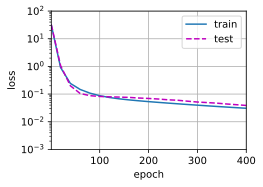

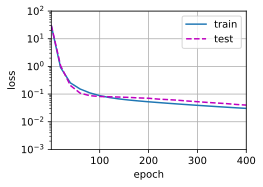

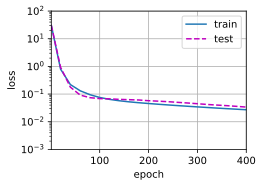

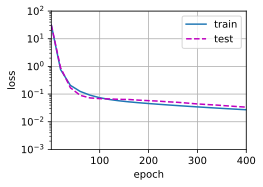

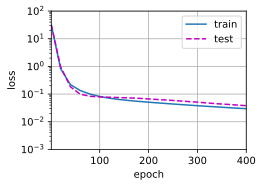

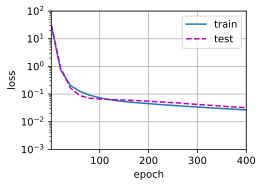

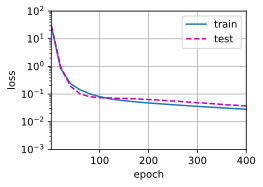

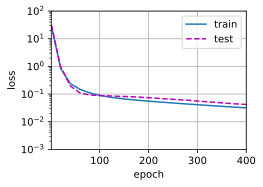

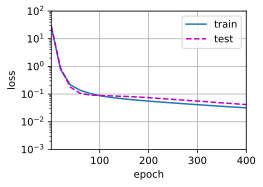

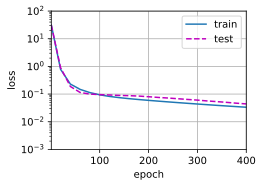

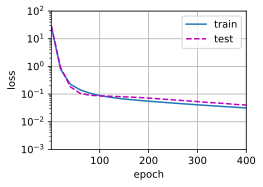

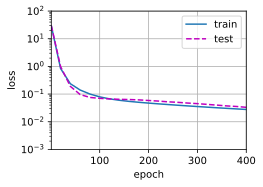

In [ ]:
from d2l import torch as d2l

train_loss_list = []
test_loss_list = []
for i in range(max_degree):
    train_loss,test_loss= train(poly_features[:n_train,:i], poly_features[n_train:,:i], labels[:n_train], labels[n_train:])
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print(train_loss_list)
print(test_loss_list)

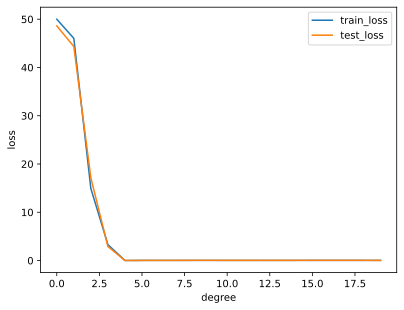

In [ ]:
# 绘制train_loss、test_loss和i之间的关系的图像
d2l.plt.plot(train_loss_list, label='train_loss')
d2l.plt.plot(test_loss_list, label='test_loss')
d2l.plt.xlabel('degree')
d2l.plt.ylabel('loss')
d2l.plt.legend()
d2l.plt.savefig('../media/loss.png')

#### 8)	4.5章节的估计问题中使用不同的λ值进行实验，绘制训练和测试精度关于λ的函数，观察到了什么？尝试解释一下。（注：λ值可以相差5-10倍间隔选取，选取技巧参考附录2）

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    train_loss = d2l.evaluate_loss(net, train_iter, loss)
    test_loss = d2l.evaluate_loss(net, test_iter, loss)
    return train_loss,test_loss

[7.325253771617301e-12, 2.5921533669537312e-11, 6.064425073226687e-11, 1.0771484681981747e-07, 3.0968934879638254e-06, 0.000915499881375581, 0.027547726035118104, 0.07608167976140975]
[155.9573844909668, 135.28080490112305, 145.74500511169433, 122.03627822875977, 104.00866413116455, 17.16788204193115, 0.2953701466321945, 0.12061257839202881]


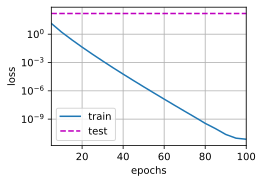

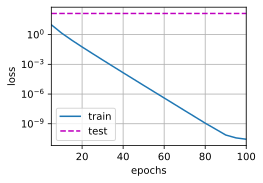

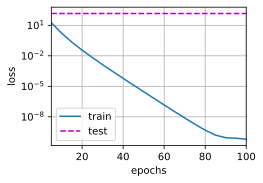

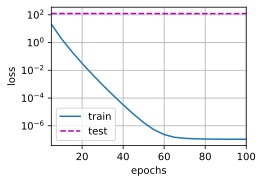

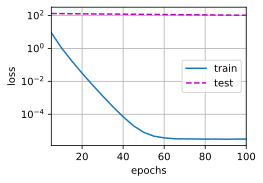

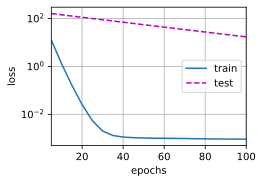

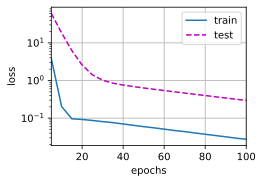

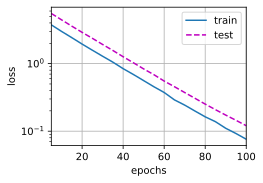

In [ ]:
from d2l import torch as d2l

train_loss_list = []
test_loss_list = []
weight_decays = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
for weight_decay in weight_decays:
    train_loss,test_loss= train_concise(weight_decay)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print(train_loss_list)
print(test_loss_list)

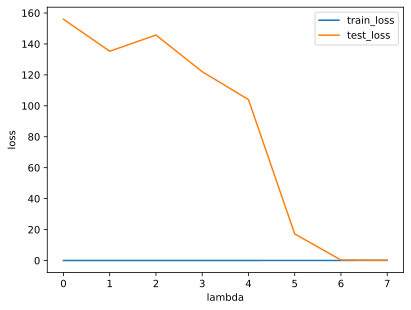

In [ ]:
# 绘制train_loss、test_loss和i之间的关系的图像
d2l.plt.plot(train_loss_list, label='train_loss')
d2l.plt.plot(test_loss_list, label='test_loss')
d2l.plt.xlabel('lambda')
d2l.plt.ylabel('loss')
d2l.plt.legend()
d2l.plt.savefig('../media/loss_lambda.png')

#### 9)	4.6章节中，如何修改超参数和网络结构可增加网络的过拟合，并利用暂退法和正则化法改善过拟合，对结果进行分析解释

In [ ]:
from d2l import torch as d2l     
import torch.nn as nn   
import torch
num_epochs, lr, batch_size = 10, 0.5, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss(reduction='none')

#### 暂退法

In [ ]:
dropout1, dropout2 = 0.2, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

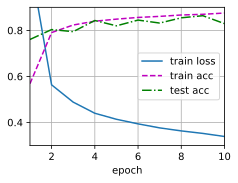

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

##### 什么都没用

In [ ]:
dropout1, dropout2 = 0.2, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        # nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        # nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
)

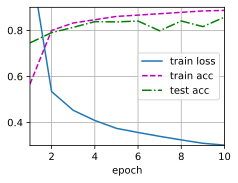

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

##### 正则化 + 暂退法

In [ ]:
dropout1, dropout2 = 0.2, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

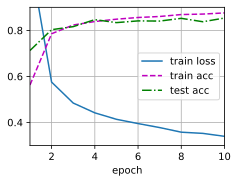

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr,weight_decay=1e-5)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

#### 10)	实战Kaggle比赛：预测房价 

In [96]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [97]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [69]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [70]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [71]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [72]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [124]:
train_data = pd.read_csv("../data/kaggle_house_pred_train.csv")
test_data = pd.read_csv("../data/kaggle_house_pred_test.csv")

In [127]:
train_data.iloc[:, :-1].shape

(1460, 80)

In [129]:
all_features = pd.concat((train_data.iloc[:, :-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 80)

In [130]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
numeric_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [131]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
all_features.shape

(2919, 331)

In [132]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [156]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Flatten(), 
                        nn.Linear(in_features, 1024),
                       nn.ReLU(),
                       nn.Linear(1024, 1))
    return net

In [118]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [135]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [120]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [121]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.046798, 验证log rmse0.120069
折2，训练log rmse0.044052, 验证log rmse0.140837
折3，训练log rmse0.045968, 验证log rmse0.134355
折4，训练log rmse0.046674, 验证log rmse0.110691
折5，训练log rmse0.044897, 验证log rmse0.156822
5-折验证: 平均训练log rmse: 0.045678, 平均验证log rmse: 0.132555


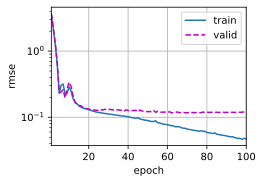

In [157]:
k, num_epochs, lr, weight_decay, batch_size =  5, 100, 0.1, 35, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [137]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.042392


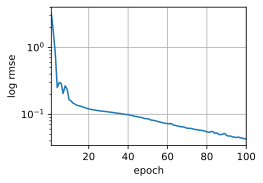

In [158]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

kaggle提交结果截图

![](../media/kaggle_submit.png)